# Transformers: Skip Connections and Normalization  
### Definition, Derivation, Computation & Visual Understanding

Skip connections (residual paths) and normalization are fundamental stabilizing components of Transformer architectures.  
They prevent gradient vanishing, enforce stable feature flow, and improve convergence.

This notebook explains:
- The mathematical definition  
- Derivation  
- Step-by-step computational interpretation  
- Visualization in 2D and 3D  
- Use-case interpretation


## 1. Residual (Skip) Connections

Given an input tensor $X$ and a function $F(X)$ (e.g. attention, feed-forward block):

The output before normalization is  
$$
Y = X + F(X)
$$

This is called **residual learning** (He et al., 2015).

### Why add skip connection?

Instead of learning mapping  
$$
H(X)
$$

learn  
$$
F(X) = H(X) - X
$$  

This implies identity function learning is easy when needed.

---

## 2. Layer Normalization (LN)

Given $X \in \mathbb{R}^{B\times T\times d}$ and per-token feature vector  
$$
x \in \mathbb{R}^{d}
$$

Compute feature mean:
$$
\mu = \frac{1}{d}\sum_{i=1}^{d}x_i
$$

Feature variance:
$$
\sigma^2 = \frac{1}{d}\sum_{i=1}^{d}(x_i - \mu)^2
$$

Normalize each feature:
$$
\hat x_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

Scale & shift:
$$
y_i = \gamma \hat x_i + \beta
$$

---

## 3. Combined Transformer Sub-Block

Transformer block applies:

1. A sub-layer (attention or feed-forward):
   $F(X)$

2. Residual connection:
   $X + F(X)$

3. Layer normalization:
$$
Z = \text{LayerNorm}(X + F(X))
$$

This enables gradient flow stability and variance control, key to Transformer training success.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

torch.manual_seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [2]:
# create toy embedding vector
x = torch.tensor([2.5, 0.5, -1.0, 3.0, 1.5], dtype=torch.float32)

print("Input vector:", x)

# 1. Compute mean
mu = x.mean()
print("Mean µ =", mu.item())

# 2. Compute variance
var = ((x-mu)**2).mean()
print("Variance σ² =", var.item())

# 3. Normalize
eps = 1e-6
x_hat = (x - mu) / torch.sqrt(var + eps)
print("Normalized x̂ =", x_hat)

# 4. Learnable scale & shift (γ, β)
gamma = torch.nn.Parameter(torch.ones_like(x))
beta  = torch.nn.Parameter(torch.zeros_like(x))

y = gamma * x_hat + beta
print("Final output y =", y)


Input vector: tensor([ 2.5000,  0.5000, -1.0000,  3.0000,  1.5000])
Mean µ = 1.2999999523162842
Variance σ² = 2.059999942779541
Normalized x̂ = tensor([ 0.8361, -0.5574, -1.6025,  1.1844,  0.1393])
Final output y = tensor([ 0.8361, -0.5574, -1.6025,  1.1844,  0.1393], grad_fn=<AddBackward0>)


In [3]:
# synthetic input (embedding)
x = torch.randn(1, 5)
print("Input X:", x)

# synthetic layer output (pretend attention)
F = torch.randn(1, 5)
print("Layer output F(X):", F)

# residual addition
y = x + F
print("Residual Applied Result Y:", y)

# layer norm
ln = nn.LayerNorm(5)
z = ln(y)
print("LayerNorm Output Z:", z)


Input X: tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845]])
Layer output F(X): tensor([[-1.3986,  0.4033,  0.8380, -0.7193, -0.4033]])
Residual Applied Result Y: tensor([[ 0.1424,  0.1099, -1.3408, -0.1508, -1.4879]])
LayerNorm Output Z: tensor([[ 0.9577,  0.9125, -1.1074,  0.5494, -1.3122]],
       grad_fn=<NativeLayerNormBackward0>)


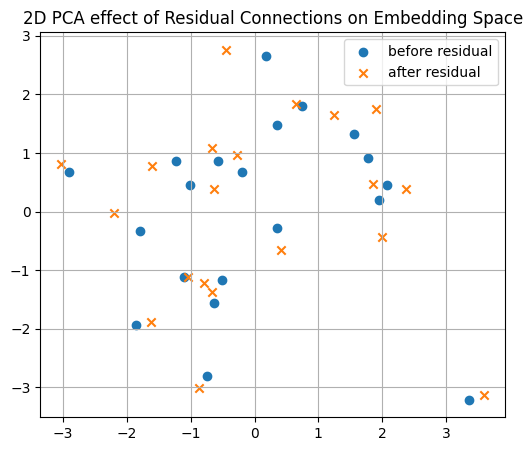

In [4]:
# simulate embeddings before & after residual blocks
samples = 20
dim = 16

X_before = torch.randn(samples, dim)
F_block = torch.randn(samples, dim) * 0.3
X_after = X_before + F_block

# PCA projection
pca = PCA(2)
combined = torch.cat([X_before, X_after], dim=0).numpy()
proj = pca.fit_transform(combined)

before2 = proj[:samples]
after2  = proj[samples:]

plt.figure(figsize=(6,5))
plt.scatter(before2[:,0], before2[:,1], label="before residual", c="C0")
plt.scatter(after2[:,0], after2[:,1], label="after residual",  c="C1", marker="x")
plt.legend()
plt.title("2D PCA effect of Residual Connections on Embedding Space")
plt.grid()
plt.show()


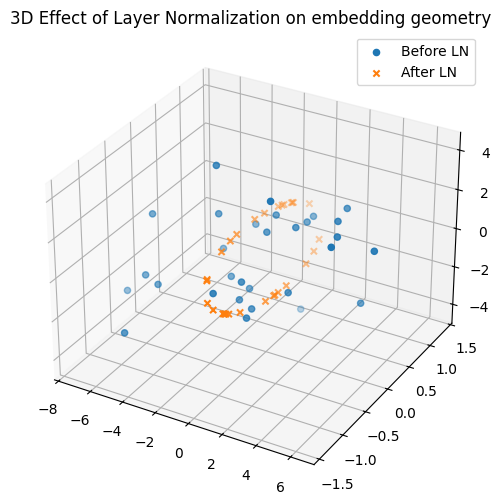

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# generate toy embeddings before and after normalization
X = torch.randn(30, 3) * torch.tensor([3.0, 0.5, 2.0])  # uneven scaling

ln = nn.LayerNorm(3)
X_norm = ln(X)

# detach so matplotlib can convert to numpy
X_np = X.detach().numpy()
Xn_np = X_norm.detach().numpy()

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_np[:,0], X_np[:,1], X_np[:,2], c="C0", label="Before LN")
ax.scatter(Xn_np[:,0], Xn_np[:,1], Xn_np[:,2], c="C1", marker="x", label="After LN")

ax.set_title("3D Effect of Layer Normalization on embedding geometry")
ax.legend()
plt.show()


In [7]:
class ResidualNormBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        print("Input x:", x)

        fx = self.linear(x)
        print("F(x) via Linear:", fx)

        y = x + fx
        print("After Residual (x + F(x)):", y)

        z = self.norm(y)
        print("After LayerNorm:", z)

        return z

block = ResidualNormBlock(dim=8)

x = torch.randn(1, 8)
out = block(x)


Input x: tensor([[-0.6140,  0.3019, -1.2309, -0.3953, -0.1270, -0.9919, -0.8773, -0.1835]])
F(x) via Linear: tensor([[ 0.2622, -0.4591,  0.2954, -1.0432,  0.3154, -0.5256,  0.1845, -0.8698]],
       grad_fn=<AddmmBackward0>)
After Residual (x + F(x)): tensor([[-0.3518, -0.1572, -0.9355, -1.4384,  0.1884, -1.5176, -0.6928, -1.0533]],
       grad_fn=<AddBackward0>)
After LayerNorm: tensor([[ 0.6915,  1.0341, -0.3356, -1.2207,  1.6422, -1.3600,  0.0915, -0.5430]],
       grad_fn=<NativeLayerNormBackward0>)


## Interpretation & Use Case

1. **Residual connections** allow easy learning of identity function:
   - If $F(X)=0$, then $Y=X$.
   - Stabilizes deep stacking in Transformers.

2. **Layer normalization**:
   - Removes feature variance
   - Reduces internal covariate shift
   - Smooths training dynamics

### Application in Transformer Encoder

Every encoder block applies:
$$
Z = \text{LayerNorm}(X + \text{MultiHead}(X,X,X))
$$

then
$$
O = \text{LayerNorm}(Z + \text{FFN}(Z))
$$

This guarantees stable gradients and expressive depth — a key reason Transformers train effectively where earlier RNNs struggled.


## Summary

✔ Defined residual (skip) connections mathematically  
✔ Derived layer normalization  
✔ Computed and printed all steps programmatically  
✔ Visualized:

- Residual change in embedding geometry (2D PCA)  
- Layer normalization stabilizing feature distribution (3D plot)

✔ Demonstrated a full Transformer sub-block with prints  
